# Importance sampling: toy example with parameters (batch method)
In this method we sample from a batch instead of one by one

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch'''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2):
    '''Makes a random image batch of size (batch_size, height, width, channels) 
    with black to white ratio of value ratio
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])]
    image_batch = torch.zeros(size) + offset # to make light gray
    image_batch[idx] = 1 - offset # to make dark gray 
    return image_batch

The dataset class

In [4]:
class BlackWhiteDataset(Dataset):
    '''The dataloader for the black and white images'''
    def __init__(self, offset=0.2):
        self.offset = offset
        self.dataset = random_image_data(offset = self.offset)

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

The weight network with parameters

In [5]:
class WeightNet(nn.Module):

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = self.softmax(self.fc2(h1))
        return out

In [6]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out

With Helge's objective function

In [7]:
weight_network = WeightNet()
optimizer_w = optim.Adam(weight_network.parameters(), lr=0.01)

offset = 0.4
dataset = BlackWhiteDataset(offset=offset)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)
sampled_batch_size = 64


example_img = torch.cat((torch.Tensor([offset, offset, offset]), 
                         torch.Tensor([1-offset, 1-offset, 1-offset])))

losses = []
example_importances = []
example_discriminations = []
for i, data in enumerate(dataloader):
    optimizer_w.zero_grad()
    
    importances = weight_network(data).squeeze() # Get the importances for each image
    sampled_idx = list( # Sample according to these importances
        torch.utils.data.sampler.WeightedRandomSampler(importances,
                                                       sampled_batch_size, 
                                                       replacement=False)
    )
    sampled_importances = importances[sampled_idx] # The importances assigned to the smaller batch
    sampled_batch = data[sampled_idx] # The sampled smaller batch
    
    # The loss function: TODO
    loss = (sampled_batch.mean(1).view(-1, 1) * (sampled_importances/
                                        sampled_importances.detach()).view(-1, 1)).mean()

    loss.backward()
    optimizer_w.step()

    losses += [loss.item()] # Store loss in a list
    w = weight_network(example_img)
    example_importances += [(w[0].item(), w[1].item())] # Store examples in a list
    
    # print statistics
    if i % 200 == 0:
        print(w[0].item(), w[1].item())
        print('step', i, 'loss: ', loss.item())
        print()

0.5059422850608826 0.4940577447414398
step 0 loss:  0.512499988079071

0.7599886059761047 0.24001142382621765
step 200 loss:  0.47187498211860657

0.9418973922729492 0.05810263380408287
step 400 loss:  0.41874998807907104

0.9774353504180908 0.022564642131328583
step 600 loss:  0.40000003576278687

0.986765444278717 0.013234561309218407
step 800 loss:  0.40000003576278687

0.9926451444625854 0.007354883011430502
step 1000 loss:  0.4031250476837158

0.9945979118347168 0.005402093753218651
step 1200 loss:  0.40000003576278687

0.9961836338043213 0.0038163771387189627
step 1400 loss:  0.40000003576278687

0.996881902217865 0.003118109190836549
step 1600 loss:  0.40000003576278687

0.9977036714553833 0.002296341583132744
step 1800 loss:  0.40312501788139343

0.9981020092964172 0.0018980019958689809
step 2000 loss:  0.40000003576278687

0.9983305335044861 0.0016694781370460987
step 2200 loss:  0.40000003576278687

0.9984880089759827 0.0015119878808036447
step 2400 loss:  0.40000003576278687

In [14]:
def amplify_visual(sampled_batch, offset=0.2):
    sampled_batch[sampled_batch < 0.5] = offset
    sampled_batch[sampled_batch > 0.5] = 1-offset
    return sampled_batch

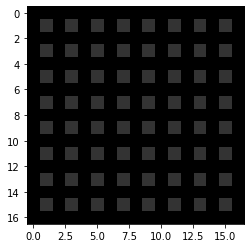

light grey = 0.4, dark grey = 0.6


In [15]:
visualize_img_batch(amplify_visual(sampled_batch))
print('light grey = {}, dark grey = {}'.format(offset, 1-offset))

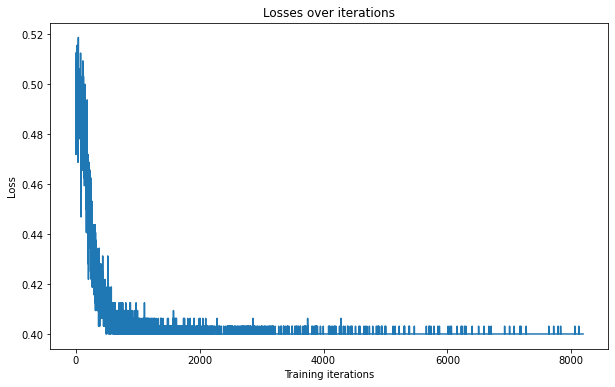

In [16]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

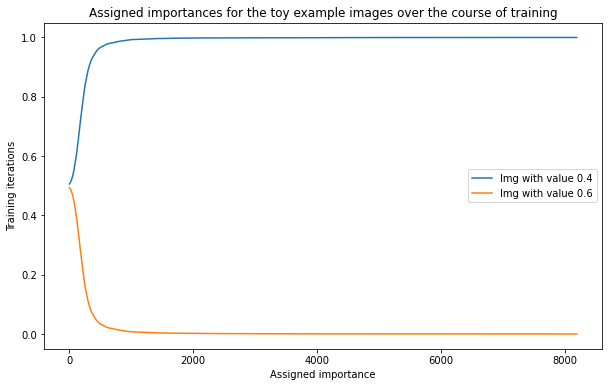

In [17]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances)
plt.legend(['Img with value {}'.format(offset), 'Img with value {}'.format(1-offset)])
plt.xlabel('Assigned importance')
plt.ylabel('Training iterations')
plt.show()

In [12]:
# plt.figure(figsize=(10,6))
# plt.title('Assigned discriminator values for the toy example images over the course of training')
# plt.plot(example_discriminations)
# plt.legend(['Img with value {}'.format(offset), 'Img with value {}'.format(1-offset)])
# plt.xlabel('Assigned importance')
# plt.ylabel('Training iterations')
# plt.show()

In [13]:
# weight_network = WeightNet()
# discriminator = Discriminator()
# optimizer_w = optim.Adam(weight_network.parameters(), lr=0.01)
# optimizer_d = optim.Adam(discriminator.parameters(), lr=0.01)

# offset = 0.4
# dataset = BlackWhiteDataset(offset=offset)
# dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)
# sampled_batch_size = 64


# example_img = torch.cat((torch.Tensor([offset, offset, offset]), 
#                          torch.Tensor([1-offset, 1-offset, 1-offset])))

# losses = []
# example_importances = []
# example_discriminations = []
# for i, data in enumerate(dataloader):
#     optimizer_w.zero_grad()
#     optimizer_d.zero_grad()
    
#     importances = weight_network(data).squeeze() # Get the importances for each image
#     sampled_idx = list( # Sample according to these importances
#         torch.utils.data.sampler.WeightedRandomSampler(importances,
#                                                        sampled_batch_size, 
#                                                        replacement=False)
#     )
#     sampled_importances = importances[sampled_idx] # The importances assigned to the smaller batch
#     sampled_batch = data[sampled_idx] # The sampled smaller batch
    
#     # The loss function: TODO
#     loss = (discriminator(sampled_batch).view(-1, 1) * (sampled_importances/
#                                         sampled_importances.detach()).view(-1, 1)).mean()

#     loss.backward()
#     optimizer_w.step()
#     optimizer_d.step()

#     losses += [loss.item()] # Store loss in a list
#     w = weight_network(example_img)
#     example_importances += [(w[0].item(), w[1].item())] # Store examples in a list
#     d = discriminator(example_img)
#     example_discriminations += [(d[0].item(), d[1].item())]
    
#     # print statistics
#     if i % 200 == 0:
#         print(w[0].item(), w[1].item())
#         print('step', i, 'loss: ', loss.item())
#         print()